# Distance Based Statistical Method for Planar Point Patterns

**Authors: Serge Rey <sjsrey@gmail.com> and Wei Kang <weikang9009@gmail.com>**

## Introduction

Distance based methods for point patterns are of three types:

* [Mean Nearest Neighbor Distance Statistics](#Mean-Nearest-Neighbor-Distance-Statistics)
* [Nearest Neighbor Distance Functions](#Nearest-Neighbor-Distance-Functions)
* [Interevent Distance Functions](#Interevent-Distance-Functions)

In addition, we are going to introduce a computational technique [Simulation Envelopes](#Simulation-Envelopes) to aid in making inferences about the data generating process. An [example](#CSR-Example) is used to demonstrate how to use and interprete simulation envelopes.

In [1]:
from scipy import spatial
import libpysal as ps
import numpy as np
from pointpats import (PointPattern, PoissonPointProcess, as_window, 
                       G, F, J, K, L, Genv, Fenv, Jenv, Kenv, Lenv)
from pointpats import ripley
%matplotlib inline
import matplotlib.pyplot as plt

## Mean Nearest Neighbor Distance Statistics

The nearest neighbor(s) for a point $u$ is the point(s) $N(u)$ which meet the condition
$$d_{u,N(u)} \leq d_{u,j} \forall j \in S - u$$

The distance between the nearest neighbor(s) $N(u)$ and the point $u$ is nearest neighbor distance for $u$. After searching for nearest neighbor(s) for all the points and calculating the corresponding distances, we are able to calculate mean nearest neighbor distance by averaging these distances.

It was demonstrated by Clark and Evans(1954) that mean nearest neighbor distance statistics distribution is a normal distribution under null hypothesis (underlying spatial process is CSR). We can utilize the test statistics to determine whether the point pattern is the outcome of CSR. If not, is it the outcome of cluster or regular
spatial process?

Mean nearest neighbor distance statistic

$$\bar{d}_{min}=\frac{1}{n} \sum_{i=1}^n d_{min}(s_i)$$

In [2]:
points = [[66.22, 32.54], [22.52, 22.39], [31.01, 81.21],
          [9.47, 31.02],  [30.78, 60.10], [75.21, 58.93],
          [79.26,  7.68], [8.23, 39.93],  [98.73, 77.17],
          [89.78, 42.53], [65.19, 92.08], [54.46, 8.48]]
pp = PointPattern(points)
kdt = spatial.KDTree(points)

## Nearest Neighbor Distance Functions

Nearest neighbour distance distribution functions (including the nearest “event-to-event” and “point-event” distance distribution functions) of a point process are cumulative distribution functions of several kinds -- $G, F, J$. By comparing the distance function of the observed point pattern with that of the point pattern from a CSR process, we are able to infer whether the underlying spatial process of the observed point pattern is CSR or not for a given confidence level.

#### $G$ function - event-to-event

The $G$ function is defined as follows: for a given distance $d$, $G(d)$ is the proportion of nearest neighbor distances that are less than $d$.
$$G(d) = \sum_{i=1}^n \frac{ \phi_i^d}{n}$$

$$ 
\phi_i^d =
 \begin{cases}
    1       & \quad \text{if } d_{min}(s_i)<d \\
    0       & \quad \text{otherwise } \\
  \end{cases}
$$

If the underlying point process is a CSR process, $G$ function has an expectation of:
$$
G(d) = 1-e(-\lambda \pi d^2)
$$
However, if the $G$ function plot is above the expectation this reflects clustering, while departures below expectation reflect dispersion.

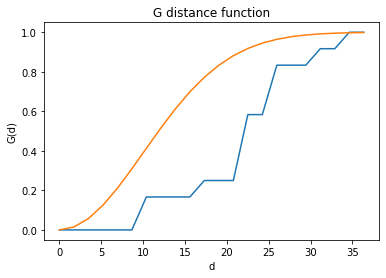

In [3]:
gp1 = G(pp, intervals=20)
gp1.plot()


In [4]:
support, gfunction = ripley.g_function(points, support=20)

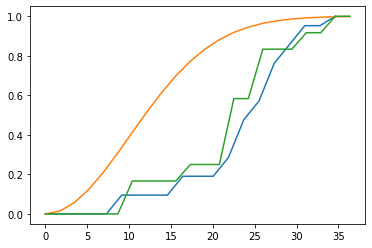

In [5]:
plt.plot(*ripley.g_function(points, support=20))
plt.plot(gp1.d, gp1.ev)
plt.plot(gp1.d, gp1.G)

in the q-q plot the csr function is now a diagonal line which serves to make accessment of departures from csr visually easier.

It is obvious that the above $G$ increases very slowly at small distances and the line is below the expected value for a CSR process (green  line). We might think that the underlying spatial process is regular point process. However, this visual inspection is not enough for a final conclusion.  In [Simulation Envelopes](#Simulation-Envelopes), we are going to demonstrate how to simulate data under CSR many times and construct the $95\%$ simulation envelope for $G$.

#### $F$ function - "point-event" 

When the number of events in a point pattern is small, $G$ function is rough (see the $G$ function plot for the 12 size point pattern above). One way to get around this is to turn to $F$ funtion where a given number of randomly distributed points are generated in the domain and the nearest event neighbor distance is calculated for each point. The cumulative distribution of all nearest event neighbor distances is called $F$ function.

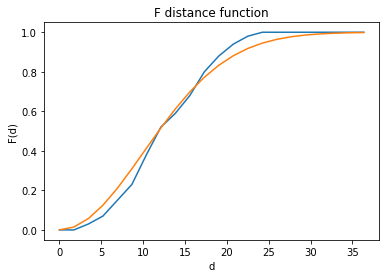

In [6]:
fp1 = F(pp, intervals=20) # The default is to randomly generate 100 points.
fp1.plot()

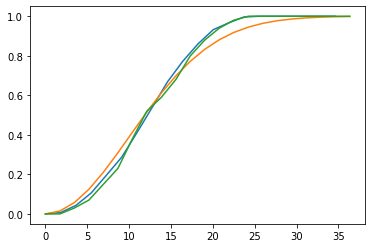

In [7]:
plt.plot(*ripley.f_function(points, support=20))
plt.plot(fp1.d, fp1.ev)
plt.plot(fp1.d, fp1.F)

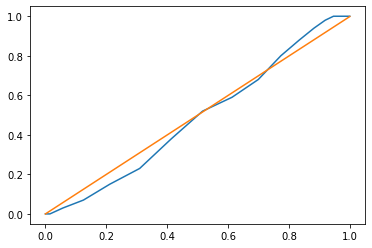

In [8]:
fp1.plot(qq=True)

We can increase the number of intervals to make $F$ more smooth.

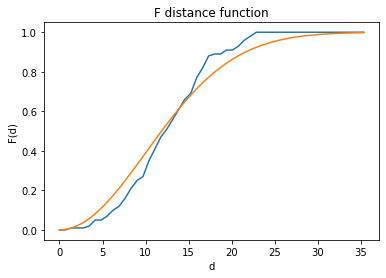

In [9]:
fp1 = F(pp, intervals=50)
fp1.plot()

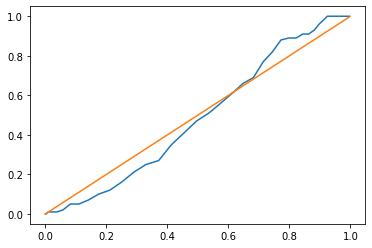

In [10]:
fp1.plot(qq=True)

$F$ function is more smooth than $G$ function. 

#### $J$ function - a combination of "event-event" and "point-event"

$J$ function is defined as follows:

$$J(d) = \frac{1-G(d)}{1-F(d)}$$

If $J(d)<1$, the underlying point process is a cluster point process; if $J(d)=1$, the underlying point process is a random point process; otherwise, it is a regular point process.

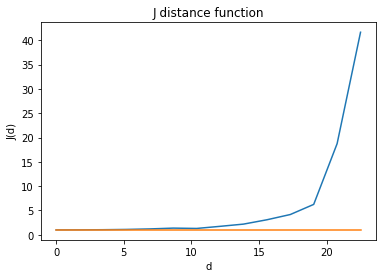

In [11]:
jp1 = J(pp, intervals=20)
jp1.plot()

/Users/lw17329/Dropbox/dev/pointpats/pointpats/ripley.py:631: UserWarning: requested 20 bins to evaluate the J function, butit reaches infinity at d=23.695060093892685, meaning only13 bins will be used to characterize the J function.
  warnings.warn(


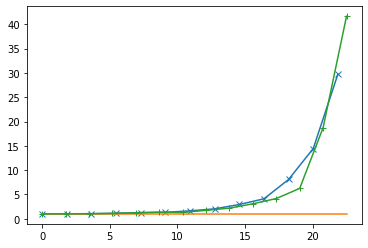

In [12]:
plt.plot(*ripley.j_function(points, support=20), marker='x')
plt.plot(jp1.d, jp1.ev)
plt.plot(jp1.d, jp1.j, marker='+')

From the above figure, we can observe that $J$ function is obviously above the $J(d)=1$ horizontal line. It is approaching infinity with nearest neighbor distance increasing. We might tend to conclude that the underlying point process is a regular one.

## Interevent Distance Functions

Nearest neighbor distance functions consider only the nearest neighbor distances, "event-event", "point-event" or the combination. Thus, distances to higer order neighbors are ignored, which might reveal important information regarding the point process. Interevent distance functions, including $K$ and $L$ functions, are proposed to consider distances between all pairs of event points. Similar to $G$, $F$ and $J$ functions, $K$ and $L$ functions are also cumulative distribution function.

#### $K$ function - "interevent"

Given distance $d$, $K(d)$ is defined as:
$$K(d) = \frac{\sum_{i=1}^n \sum_{j=1}^n \psi_{ij}(d)}{n \hat{\lambda}}$$

where
$$ 
\psi_{ij}(d) =
 \begin{cases}
    1       & \quad \text{if } d_{ij}<d \\
    0       & \quad \text{otherwise } \\
  \end{cases}
$$

$\sum_{j=1}^n \psi_{ij}(d)$ is the number of events within a circle of radius $d$ centered on event $s_i$ .

Still, we use CSR as the benchmark (null hypothesis) and see how the $K$ funtion estimated from the observed point pattern deviate from that under CSR, which is $K(d)=\pi d^2$. $K(d)<\pi d^2$ indicates that the underlying point process is a regular point process. $K(d)>\pi d^2$ indicates that the underlying point process is a cluster point process. 

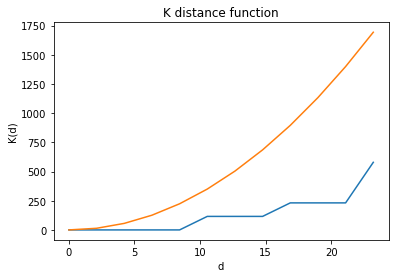

In [13]:
kp1 = K(pp)
kp1.plot()

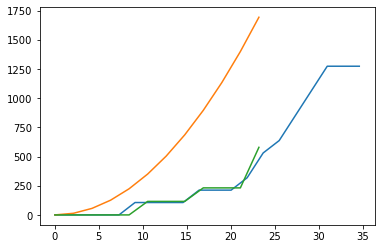

In [17]:
plt.plot(*ripley.k_function(points, support=20))
plt.plot(kp1.d, kp1.ev)
plt.plot(kp1.d, kp1.k)

#### $L$ function - "interevent"

$L$ function is a scaled version of $K$ function, defined as:
$$L(d) = \sqrt{\frac{K(d)}{\pi}}-d$$

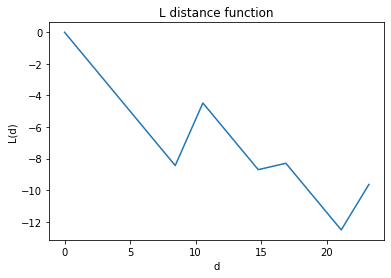

In [18]:
lp1 = L(pp)
lp1.plot()

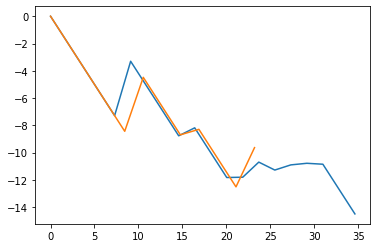

In [23]:
plt.plot(*ripley.l_function(points, support=20, linearized=True))
plt.plot(lp1.d, lp1.l)

## Simulation Envelopes

A [Simulation envelope](http://www.esajournals.org/doi/pdf/10.1890/13-2042.1) is a computer intensive technique for inferring whether an observed pattern significantly deviates from what would be expected under a specific process. Here, we always use CSR as the benchmark. In order to construct a simulation envelope for a given function, we need to simulate CSR a lot of times, say $1000$ times. Then, we can calculate the function for each simulated point pattern. For every distance $d$, we sort the function values of the $1000$ simulated point patterns. Given a confidence level, say $95\%$, we can acquire the $25$th and $975$th value for every distance $d$. Thus, a simulation envelope is constructed. 

#### Simulation Envelope for G function

**Genv** class in pysal.

In [23]:
realizations = PoissonPointProcess(pp.window, pp.n, 100, asPP=True) # simulate CSR 100 times
genv = Genv(pp, intervals=20, realizations=realizations) # call Genv to generate simulation envelope
genv

In [24]:
genv.observed 

array([[ 0.        ,  0.        ],
       [ 1.73156208,  0.        ],
       [ 3.46312417,  0.        ],
       [ 5.19468625,  0.        ],
       [ 6.92624834,  0.        ],
       [ 8.65781042,  0.        ],
       [10.3893725 ,  0.16666667],
       [12.12093459,  0.16666667],
       [13.85249667,  0.16666667],
       [15.58405875,  0.16666667],
       [17.31562084,  0.25      ],
       [19.04718292,  0.25      ],
       [20.77874501,  0.25      ],
       [22.51030709,  0.58333333],
       [24.24186917,  0.58333333],
       [25.97343126,  0.83333333],
       [27.70499334,  0.83333333],
       [29.43655542,  0.83333333],
       [31.16811751,  0.91666667],
       [32.89967959,  0.91666667],
       [34.63124168,  1.        ],
       [36.36280376,  1.        ]])

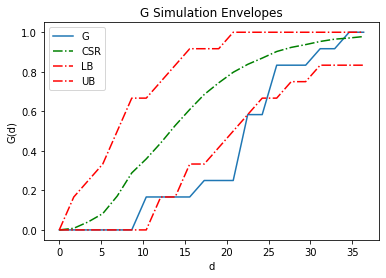

In [25]:
genv.plot()

In the above figure, **LB** and **UB** comprise the simulation envelope. **CSR** is the mean function calculated from the simulated data. **G** is the function estimated from the observed point pattern. It is well below the simulation envelope. We can infer that the underlying point process is a regular one.

#### Simulation Envelope for F function

**Fenv** class in pysal.

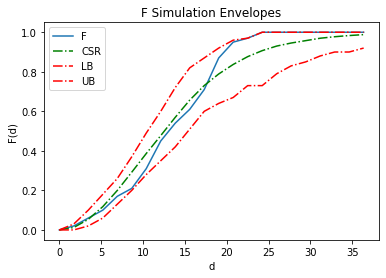

In [26]:
fenv = Fenv(pp, intervals=20, realizations=realizations)
fenv.plot()

#### Simulation Envelope for J function

**Jenv** class in pysal.

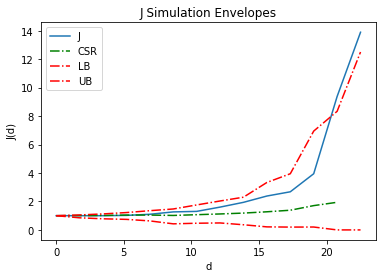

In [27]:
jenv = Jenv(pp, intervals=20, realizations=realizations)
jenv.plot()

#### Simulation Envelope for K function

**Kenv** class in pysal.

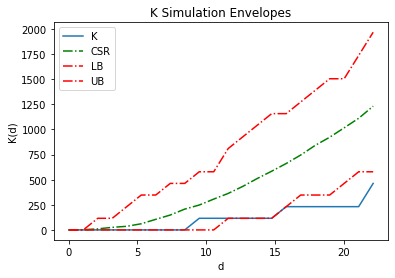

In [28]:
kenv = Kenv(pp, intervals=20, realizations=realizations)
kenv.plot()

#### Simulation Envelope for L function

**Lenv** class in pysal.

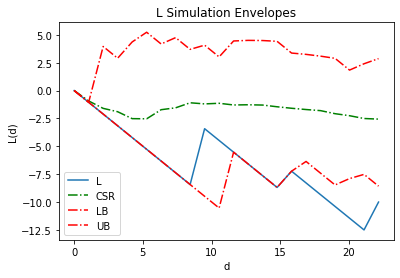

In [29]:
lenv = Lenv(pp, intervals=20, realizations=realizations)
lenv.plot()

## CSR Example
In this example, we are going to generate a point pattern as the "observed" point pattern. The data generating process is CSR. Then, we will simulate CSR in the same domain for 100 times and construct a simulation envelope for each function.

In [30]:
from libpysal.cg import shapely_ext
from pointpats import Window
import libpysal as ps
va = ps.io.open(ps.examples.get_path("vautm17n.shp"))
polys = [shp for shp in va]
state = shapely_ext.cascaded_union(polys)

Generate the point pattern **pp** (size 100) from CSR as the "observed" point pattern.

In [31]:
a = [[1],[1,2]]
np.asarray(a)

array([list([1]), list([1, 2])], dtype=object)

In [32]:
n = 100
samples = 1
pp = PoissonPointProcess(Window(state.parts), n, samples, asPP=True)
pp.realizations[0]

In [33]:
pp.n

100

Simulate CSR in the same domian for 100 times which would be used for constructing simulation envelope under the null hypothesis of CSR.

In [34]:
csrs = PoissonPointProcess(pp.window, 100, 100, asPP=True)
csrs

Construct the simulation envelope for $G$ function.

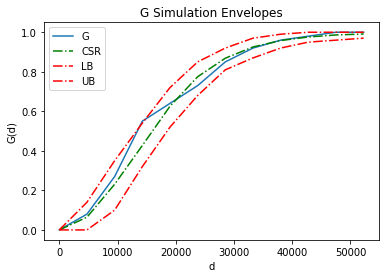

In [35]:
genv = Genv(pp.realizations[0], realizations=csrs)
genv.plot()

Since the "observed" $G$ is well contained by the simulation envelope, we infer that the underlying point process is a random process.

In [36]:
genv.low # lower bound of the simulation envelope for G

array([0.  , 0.  , 0.1 , 0.32, 0.52, 0.68, 0.81, 0.87, 0.92, 0.95, 0.96,
       0.97])

In [37]:
genv.high # higher bound of the simulation envelope for G

array([0.  , 0.14, 0.35, 0.54, 0.72, 0.85, 0.92, 0.97, 0.99, 1.  , 1.  ,
       1.  ])

Construct the simulation envelope for $F$ function.

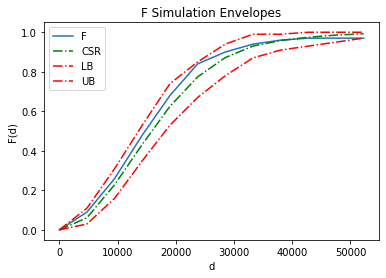

In [38]:
fenv = Fenv(pp.realizations[0], realizations=csrs)
fenv.plot()

Construct the simulation envelope for $J$ function.

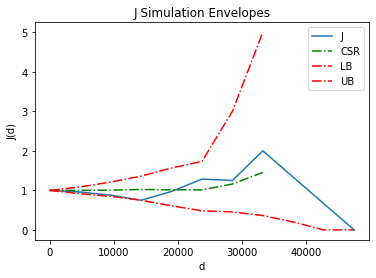

In [39]:
jenv = Jenv(pp.realizations[0], realizations=csrs)
jenv.plot()

Construct the simulation envelope for $K$ function.

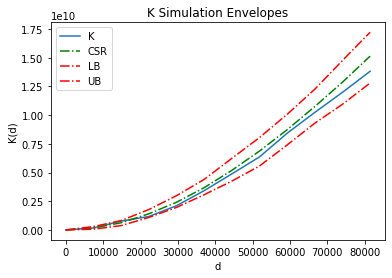

In [40]:
kenv = Kenv(pp.realizations[0], realizations=csrs)
kenv.plot()

Construct the simulation envelope for $L$ function.

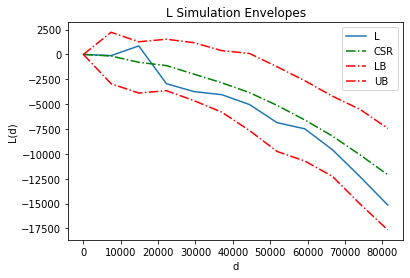

In [41]:
lenv = Lenv(pp.realizations[0], realizations=csrs)
lenv.plot()